In [1]:
import torch
import pandas as pd
import numpy as np
import random

import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# tempDf = pd.read_csv('names/Indian-Male-Names.csv')
# namesList = tempDf['name'][tempDf['name'].notna()].tolist()
# tempDf = pd.read_csv('names/Indian-Female-Names.csv')
# namesList.extend(tempDf['name'][tempDf['name'].notna()].tolist())

In [3]:
# namesList = namesList + open('names/names.txt', 'r').read().splitlines()

In [4]:
namesList = open('names/manga_names.txt', 'r').read().splitlines()

In [5]:
uniqueChar = set()
for name in namesList:
        for char in name:
            uniqueChar.add(char)


In [6]:
startChar = '<S>'
endChar = '<E>'
uniqueChar.add(startChar)
uniqueChar.add(endChar)
print(f'Total names :- {len(namesList)}')
print(f'Total unique characters :- {len(uniqueChar)}')

Total names :- 116943
Total unique characters :- 155


In [7]:
namesList[-5:] + namesList[:5]

['フォケイロン',
 'Fokeiron',
 '原',
 'Hara',
 'Yuan',
 '"Asakusa"',
 '"Buzz" Sebastian',
 '"Minnie C" Tachibana',
 '"Musashi"',
 '"Musashino"']

In [8]:
def generate_batch(dataset, batch_size):
    while True:
        random.shuffle(dataset)
        for i in range(0, len(dataset), batch_size):
            yield dataset[i: i+batch_size]
            

In [9]:
class MLP:
    def __init__(self, input_size, layer_size, output_size, has_bias = False):
        self.layer1 = torch.randn(input_size, layer_size)
        self.layer2 = torch.randn(layer_size, output_size)
        self.bias2 = torch.randn(output_size)
        self.scale_factor = torch.ones(1, layer_size)
        self.shift = torch.zeros(1, layer_size)
        
        self.layer1.requires_grad = True
        self.layer2.requires_grad = True
        self.scale_factor.requires_grad = True
        self.shift.requires_grad = True
        
        self.running_mean = torch.zeros(1, layer_size)
        self.running_var = torch.ones(1, layer_size)
        self.exp_weight = 1e-3
        
    def forward(self, input_tensor, is_training = False):
        layer_out = input_tensor @ self.layer1
        if is_training:
            mean = layer_out.mean(dim = 0, keepdim = True)
            variance = layer_out.var(dim = 0, keepdim = True)
            self.running_mean = self.running_mean*(1 - self.exp_weight) + mean*self.exp_weight
            self.running_var = self.running_var*(1 - self.exp_weight) + variance*self.exp_weight
        else:
            mean = self.running_mean
            variance = self.running_var
        layer_out = self.scale_factor * (layer_out - mean)/(variance**0.5 + 1e-7) + self.shift
        layer_out = F.tanh(layer_out)
        layer_out = layer_out @ self.layer2 + self.bias2
        return layer_out
    
    def get_parameters(self):
        parameters = [self.layer1, self.layer2, self.bias2, self.scale_factor, self.shift]
        return parameters
    
    def flush_gradients(self):
        parameters = self.get_parameters()
        for p in parameters:
            p.grad = None
    
    def apply_gradients(self, lr):
        parameters = self.get_parameters()
        for p in parameters:
            if p.grad is not None:
                p.data -= lr * p.grad
        

In [10]:
class Embedding:
    def __init__(self, embedding_size, vocab_size):
        self.embedding_lookup = {}
        for token in range(vocab_size):
            self.embedding_lookup[token] = torch.randn(embedding_size)
            self.embedding_lookup[token].requires_grad = True
            
    def forward(self, input_token):
        if type(input_token) is list:
            output = []
            for token in input_token:
                output.append(self.embedding_lookup[token])
            return output
        
        return self.embedding_lookup[input_token]
    
    def get_parameters(self):
        parameters = []
        for key in self.embedding_lookup:
            parameters.append(self.embedding_lookup[key])
        return parameters
    
    def flush_gradients(self):
        parameters = self.get_parameters()
        for p in parameters:
            p.grad = None
            
    def apply_gradients(self, lr):
        parameters = self.get_parameters()
        for p in parameters:
            if p.grad is not None:
                p.data -= lr * p.grad


In [15]:
sequence_size = 8
all_sequences = []
for name in namesList:
    sequence = []
    for i in range(sequence_size+1):
        sequence += [startChar]
    for i in range(len(name)+1):
        if i == len(name):
            char = endChar
        else:
            char = name[i]
        sequence = sequence[1:] + [char]
        all_sequences.append(sequence)
        

In [16]:
train_size = 0.95
random.shuffle(all_sequences)
train_length = int(len(all_sequences) * train_size)
train_sequences = all_sequences[:train_length]
val_sequence = all_sequences[train_length:]
print(len(train_sequences), len(val_sequence))

1457732 76723


In [17]:

embedding_size = 20
layer_size = 300

char_to_idx_map = {}
idx_to_char_map = {}
idx = 0

for char in uniqueChar:
    char_to_idx_map[char] = idx
    idx_to_char_map[idx] = char
    idx+=1

char_embedding = Embedding(embedding_size, len(uniqueChar))
model = MLP(embedding_size * sequence_size, layer_size, len(uniqueChar))
parameters = [char_embedding, model]

loss_arr = []


In [18]:
num_iterations = 200000
batch_size = 32
idx = 0  

batch_generator = generate_batch(train_sequences, batch_size)
for i in range(num_iterations):
    for p in parameters:
        p.flush_gradients()
    
    idx += 1
    batch = next(batch_generator)
    X = []
    Y = []
    for row in batch:
        input_sequence = row[:-1]
        next_char = row[-1]
        input_embedding = char_embedding.forward([char_to_idx_map[char] for char in input_sequence])
        ohe = F.one_hot(torch.tensor(char_to_idx_map[next_char]), len(uniqueChar))
        X.append(torch.cat(input_embedding))
        Y.append(ohe)
        
    X = torch.stack(X)
    Y = torch.stack(Y)
    # print(X)
    # print("------")
    # print(X.shape)
    output = model.forward(X, is_training = True)
    
    # print(output.shape)
    # print(Y.shape)
    # print(Y[0])
    # print(output)
    # break
    loss = F.cross_entropy(output, Y.float())
    loss_arr.append(loss.log10().item())
    
    if idx < 100000:
        lr = 0.1
        
    elif idx < 150000:
        lr = 0.01
    else:
        lr = 0.002
        
    loss.backward()
    for p in parameters:
        p.apply_gradients(lr)
        
    if idx % 5000 == 0:
        print(idx, " : ", np.mean(loss_arr[-1000:]), " ", 10**np.mean(loss_arr[-1000:]))
    

5000  :  0.4886968391537666   3.081036470672932
10000  :  0.46058952051401136   2.887949006728815
15000  :  0.44584834069013596   2.791568831536733
20000  :  0.4368578822016716   2.7343737879903975
25000  :  0.43226591154932975   2.705614461418675
30000  :  0.4265507118403912   2.670242548683154
35000  :  0.42196820652484895   2.6422153211038433
40000  :  0.4206607137620449   2.6342725946366294
45000  :  0.41457245182991026   2.597601053958346
50000  :  0.413850968927145   2.593289304743632
55000  :  0.40904722931981086   2.5647629381105412
60000  :  0.4077883288860321   2.557339159653438
65000  :  0.4061742537021637   2.547852332448905
70000  :  0.405480238199234   2.543784040111461
75000  :  0.40387687519192694   2.534410009845401
80000  :  0.4003473098278046   2.5138960167292743
85000  :  0.4012217061817646   2.518962523275139
90000  :  0.3957618766129017   2.487493053451043
95000  :  0.3962904013991356   2.490522108832163
100000  :  0.3941931967288256   2.478524388730939
105000  : 

In [19]:
# Validation set
with torch.no_grad():
    X = []
    Y = []
    for row in val_sequence:
        input_sequence = row[:-1]
        next_char = row[-1]
        input_embedding = char_embedding.forward([char_to_idx_map[char] for char in input_sequence])
        ohe = F.one_hot(torch.tensor(char_to_idx_map[next_char]), len(uniqueChar))
        X.append(torch.cat(input_embedding))
        Y.append(ohe)
        
    X_val = torch.stack(X)
    Y_val = torch.stack(Y)
    
    output = model.forward(X_val)
    loss = F.cross_entropy(output, Y_val.float())
    print("Validation loss: ", loss.item(), "log value:", loss.log10().item())

Validation loss:  2.3117220401763916 log value: 0.3639356195926666


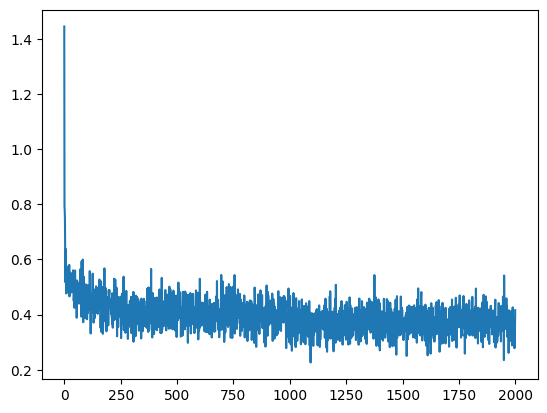

In [20]:
sampled_data = loss_arr[::100]  # Adjust the step for sampling as needed
plt.plot(sampled_data)

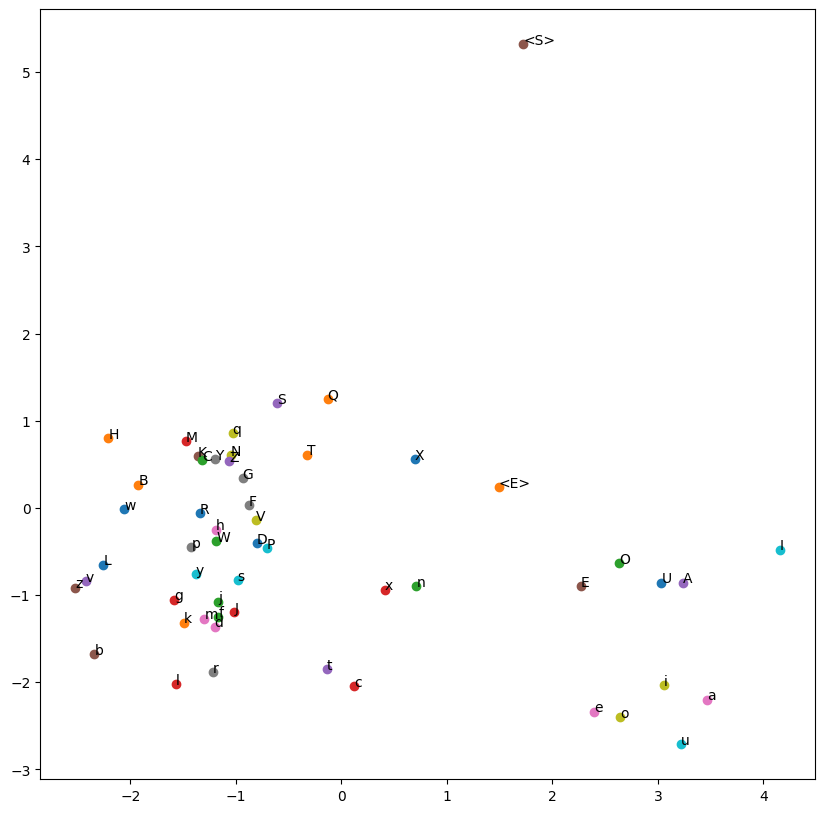

In [21]:
## For embeddings greater than 2, supress data to 2 dimensions
embeddings = []
chars = []

for char in uniqueChar:
    idx = char_to_idx_map[char]
    embeddings.append(char_embedding.forward(idx))
    chars.append(char)

embedding_tensor = torch.stack(embeddings)

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_tensor.detach().numpy())

# Plot
plt.figure(figsize=(10, 10))
for i, char in enumerate(chars):
    if (char.isascii() and char.isalpha()) or char == startChar or char == endChar:
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(char, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))


In [22]:
def next_char_generate(sequence):
    sequence = sequence[-sequence_size:]
    input_tensor = []
    for char in sequence:
        input_tensor.append(char_embedding.forward(char_to_idx_map[char]))
    input_tensor = torch.cat(input_tensor)
    out = model.forward(input_tensor)
    # print(out)
    # Sample an index, treating the tensor's values as probabilities
    sampled_index = torch.multinomial(F.softmax(out), num_samples=1).item()
    return idx_to_char_map[sampled_index]

In [23]:
start_sequence = []
for i in range(sequence_size):
    start_sequence.append(startChar)

In [24]:
def gen_name(sequence):
    name = ''
    for char in sequence:
        if char != startChar:
            name += char
    while True:
        # print(sequence)
        next_char = next_char_generate(sequence)
        # print(next_char)
        sequence = sequence[1:] + [next_char]
        if next_char == endChar:
            break
        name += next_char
        
    return name

In [25]:
names = []
for i in range(10):
    names.append(gen_name(start_sequence))
names

/var/folders/74/h39_kcwj7_j6r865dqfty2cc0000gn/T/ipykernel_22647/3507051933.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sampled_index = torch.multinomial(F.softmax(out), num_samples=1).item()


['Sniki',
 'Mitama Ne Tehefura',
 'Makukaka A',
 'Memono Lyyukchichi',
 'Madu Shoru',
 'Yumekoro',
 'Samisey Wohoro',
 'Sarimei Okota Kunor',
 'Youka reshi',
 'Mino Kizuko']

In [27]:
prefix = ['k', 'a']
resList = []
for i in range(10):
    while(len(prefix) < sequence_size):
        prefix = ['<S>'] + prefix
    resList.append(gen_name(prefix))
    
resList

/var/folders/74/h39_kcwj7_j6r865dqfty2cc0000gn/T/ipykernel_22647/3507051933.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sampled_index = torch.multinomial(F.softmax(out), num_samples=1).item()


['kaki Ryou',
 'kanzoro No Eminozu',
 'kagleima',
 'kageya Panshi',
 'kala-Stio Conoon',
 'kao vam.',
 'kaipan',
 'kamama Shiimi',
 'karian',
 'kaichina Komadai']